# Data download from Kaggle

In [ ]:
!/bin/bash
!curl -L -o archive.zip\
https://www.kaggle.com/api/v1/datasets/download/rm1000/lung-cancer-histopathological-images

# resnet18 

In [32]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary

# Step 1: Choose a Pre-trained Model
import torchvision.models as models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the model and move it to the appropriate device (GPU or CPU)
model = models.resnet18(pretrained=True).to(device)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\Duke\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duke\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# Step 2: Load and modify the model

num_classes = 3
batch_size = 32
num_epochs = 5
learning_rate = 0.001

classes = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']


num_features = model.fc.in_features
print(num_features)

model.fc = torch.nn.Linear(num_features, num_classes).to(device)
print(model)


def test(model, test_loader, device):
    # Set Model to evaluation mode
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images)
            _, predicted = torch.max(predicted_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total * 100
    return acc


512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [34]:
# Step 3: Freeze the pretrained model

# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the fully connected layer (classifier)
for param in model.fc.parameters():
    param.requires_grad = True


In [35]:
# Step 4: Data Preprocessing

import torchvision.transforms as transforms

transform = [torchvision.transforms.Resize((224, 224)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

transformation = torchvision.transforms.Compose(transform)

data_path = 'Lung Cancer'

full_dataset = torchvision.datasets.ImageFolder(root=data_path,
                                 transform=transformation)

train_size = int(0.7 * len(full_dataset))  # 70% data will be trained
test_size = len(full_dataset) - train_size  # 30% data will be tested
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])



# Train Loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Test Loader
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')



Training dataset size: 10500
Testing dataset size: 4500


In [36]:
# Step 5: Model Training

# Loss & Optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

epoch_loss = 0
loss_list = []
training_loss = []
training_acc = []
epoch_nums = []

model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Move data to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)  # No need to one-hot encode if using CrossEntropyLoss
        
        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.log_softmax(outputs, dim=1)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        loss_list.append(epoch_loss)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / (i + 1)
    training_loss.append(avg_loss)

    # Calculate accuracy
    accuracy = test(model, test_loader, device)
    training_acc.append(accuracy)

    epoch_nums.append(epoch)
    epoch_loss = 0


Epoch [1/5], Step [100/329], Loss: 0.2148
Epoch [1/5], Step [200/329], Loss: 0.1010
Epoch [1/5], Step [300/329], Loss: 0.1770
Epoch [2/5], Step [100/329], Loss: 0.0719
Epoch [2/5], Step [200/329], Loss: 0.0905
Epoch [2/5], Step [300/329], Loss: 0.0369
Epoch [3/5], Step [100/329], Loss: 0.0910
Epoch [3/5], Step [200/329], Loss: 0.1840
Epoch [3/5], Step [300/329], Loss: 0.0687
Epoch [4/5], Step [100/329], Loss: 0.1067
Epoch [4/5], Step [200/329], Loss: 0.0863
Epoch [4/5], Step [300/329], Loss: 0.1041
Epoch [5/5], Step [100/329], Loss: 0.0567
Epoch [5/5], Step [200/329], Loss: 0.0627
Epoch [5/5], Step [300/329], Loss: 0.0779


In [37]:
# Set Model to evaluation mode
model.eval

with torch.no_grad():
  correct = 0
  total = 0
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predicted_output = model(images)
    _,predicted = torch.max(predicted_output.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
acc = correct /total *100
print(acc)


# making predction based on the test dataset


96.62222222222222


In [38]:
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to store predictions and true labels
y_pred = []
y_true = []

# Set model to evaluation mode
model.eval()

# Disable gradient calculation during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        predicted_output = model(images)

        # Get the predicted class with the highest probability
        _, predicted = torch.max(predicted_output, 1)
        
        # Store predictions and true labels in lists
        y_pred.extend(predicted.cpu().numpy())  # Move predictions to CPU
        y_true.extend(labels.cpu().numpy())    # Move true labels to CPU

# Calculate confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[1418    0   51]
 [  10 1556    0]
 [  91    0 1374]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1469
           1       1.00      0.99      1.00      1566
           2       0.96      0.94      0.95      1465

    accuracy                           0.97      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.97      0.97      0.97      4500



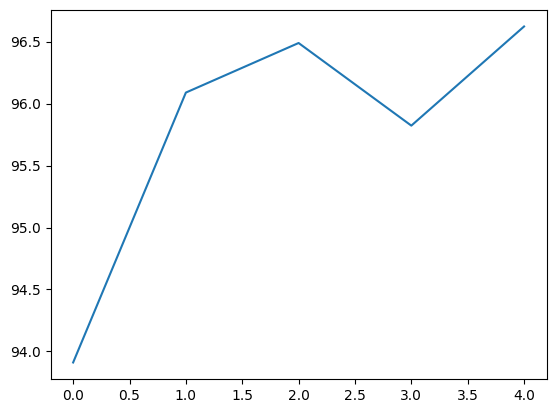

In [39]:
plt.plot(epoch_nums, training_acc)
plt.show()

[1.2870159149169922, 2.3895952701568604, 3.555591106414795, 4.652959108352661, 5.688025951385498, 6.611882567405701, 7.445762574672699, 8.333119213581085, 9.104407668113708, 9.878682315349579, 10.530054569244385, 11.190465033054352, 12.170519828796387, 12.837983548641205, 13.69495302438736, 14.268827676773071, 15.001529812812805, 15.57284951210022, 16.132445573806763, 16.62101086974144, 17.49050948023796, 17.973987370729446, 18.488841861486435, 19.01150146126747, 19.611130326986313, 20.077398717403412, 20.581892788410187, 21.011667639017105, 21.53091475367546, 22.107357531785965, 22.53748592734337, 22.920211732387543, 23.461000561714172, 23.86391520500183, 24.23431098461151, 24.654826939105988, 25.00639832019806, 25.388264060020447, 25.66596570611, 26.058471500873566, 26.448027998209, 26.78563219308853, 27.109345585107803, 27.420287996530533, 27.698336511850357, 28.033084630966187, 28.33505266904831, 28.67573207616806, 29.176191449165344, 29.43385797739029, 29.67846429347992, 29.925846

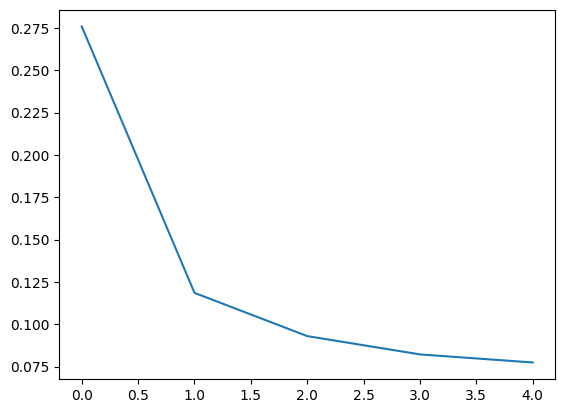

In [40]:
print(loss_list)

#plt.plot(loss_list)
plt.plot(training_loss)
plt.show()

Training Accuracy values:
Epoch 0: Accuracy = 93.91%
Epoch 1: Accuracy = 96.09%
Epoch 2: Accuracy = 96.49%
Epoch 3: Accuracy = 95.82%
Epoch 4: Accuracy = 96.62%


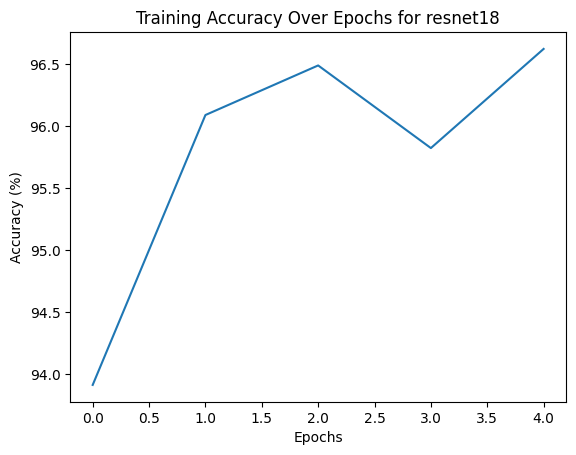

Training Loss values:
Epoch 0: Loss = 0.2759
Epoch 1: Loss = 0.1185
Epoch 2: Loss = 0.0930
Epoch 3: Loss = 0.0822
Epoch 4: Loss = 0.0774


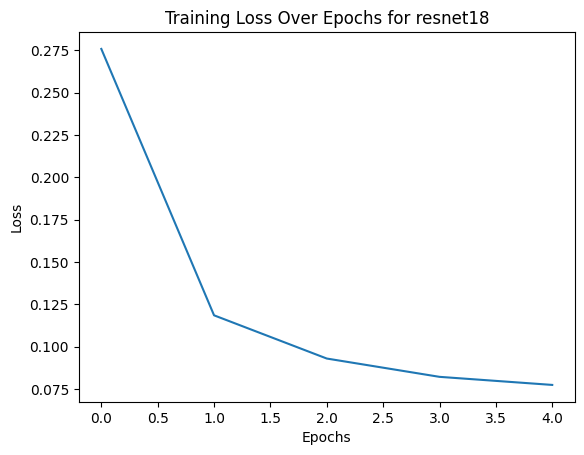

In [41]:
# Print the exact training accuracy values
print("Training Accuracy values:")
for epoch, acc in zip(epoch_nums, training_acc):
    print(f"Epoch {epoch}: Accuracy = {acc:.2f}%")

# Plot the training accuracy graph
plt.plot(epoch_nums, training_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs for resnet18')
plt.show()

# Print the exact training loss values
print("Training Loss values:")
for epoch, loss in zip(epoch_nums, training_loss):
    print(f"Epoch {epoch}: Loss = {loss:.4f}")

# Plot the training loss graph
plt.plot(epoch_nums, training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for resnet18')
plt.show()


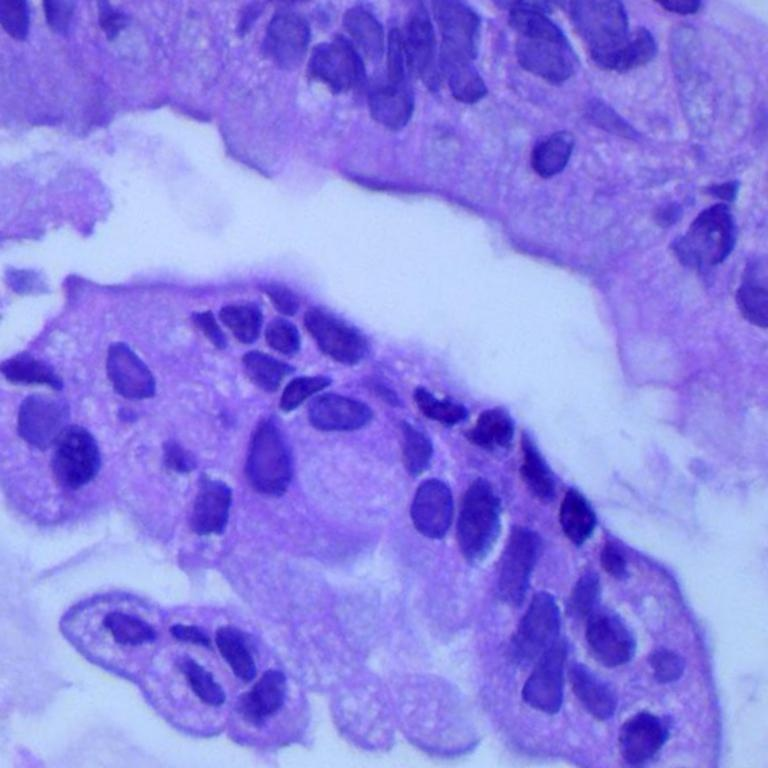

torch.Size([1, 3, 224, 224])
tensor([0], device='cuda:0')
adenocarcinoma


In [42]:
model.eval()  # Switch model to evaluation mode

from PIL import Image

# Open the image
img = Image.open('adenocarcinoma.jpg')

# Display the image (use .show() instead of display)
display(img)

# Define the transformations
transforms = [torchvision.transforms.Resize((224, 224)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

# Compose the transformations
transformations = torchvision.transforms.Compose(transforms)

# Apply the transformations to the image
transformed = transformations(img)

# Add batch dimension (unsqueeze)
transformed = transformed.unsqueeze(0)

# Check the size of the tensor
print(transformed.size())

# Move the transformed image to the same device as the model (GPU or CPU)
transformed = transformed.to(device)

# Pass the transformed image through the model
predicted_output = model(transformed)

# Get the predicted class
_, predicted = torch.max(predicted_output, 1)

# Print the predicted class index
print(predicted)

# Convert the predicted class index to a class name
predicted = predicted.cpu().data.numpy()[0]

# Print the predicted class label
print(classes[predicted])


In [43]:
#torch.save(model.state_dict(),'lung_resnet.pt')

# VGG16

In [44]:
import torch
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn

# Step 1: Choose a Pre-trained Model


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the model and move it to the appropriate device (GPU or CPU)
model = models.vgg16(pretrained=True).to(device)

print(model)

c:\Users\Duke\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duke\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
# Step 2: Load and modify the model

# Number of classes for your problem
num_classes = 3
batch_size = 32
num_epochs = 5
learning_rate = 0.001

classes = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

# Modify the final fully connected layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes).to(device)

# Check the model
print(model)

def test(model, test_loader, device):
    # Set Model to evaluation mode
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images)
            _, predicted = torch.max(predicted_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total * 100
    return acc


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the final fully connected layer (classifier[6])
for param in model.classifier[6].parameters():
    param.requires_grad = True


In [47]:
# Step 4: Data Preprocessing

import torchvision.transforms as transforms

transform = [torchvision.transforms.Resize((224, 224)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

transformation = torchvision.transforms.Compose(transform)

data_path = 'Lung Cancer'

full_dataset = torchvision.datasets.ImageFolder(root=data_path,
                                 transform=transformation)

train_size = int(0.7 * len(full_dataset))  # 70% data will be trained
test_size = len(full_dataset) - train_size  # 30% data will be tested
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])



# Train Loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Test Loader
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

Training dataset size: 10500
Testing dataset size: 4500


In [48]:
# Step 5: Model Training

# Loss & Optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

epoch_loss = 0
loss_list = []
training_loss = []
training_acc = []
epoch_nums = []

model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Move data to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)  # No need to one-hot encode if using CrossEntropyLoss
        
        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.log_softmax(outputs, dim=1)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        loss_list.append(epoch_loss)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / (i + 1)
    training_loss.append(avg_loss)

    # Calculate accuracy
    accuracy = test(model, test_loader, device)
    training_acc.append(accuracy)

    epoch_nums.append(epoch)
    epoch_loss = 0

Epoch [1/5], Step [100/329], Loss: 0.1871
Epoch [1/5], Step [200/329], Loss: 0.4775
Epoch [1/5], Step [300/329], Loss: 0.4729
Epoch [2/5], Step [100/329], Loss: 0.1241
Epoch [2/5], Step [200/329], Loss: 0.1487
Epoch [2/5], Step [300/329], Loss: 0.2001
Epoch [3/5], Step [100/329], Loss: 0.1266
Epoch [3/5], Step [200/329], Loss: 0.2476
Epoch [3/5], Step [300/329], Loss: 0.0469
Epoch [4/5], Step [100/329], Loss: 0.1871
Epoch [4/5], Step [200/329], Loss: 0.0142
Epoch [4/5], Step [300/329], Loss: 0.0650
Epoch [5/5], Step [100/329], Loss: 0.0324
Epoch [5/5], Step [200/329], Loss: 0.0216
Epoch [5/5], Step [300/329], Loss: 0.1281


In [49]:
# Set Model to evaluation mode
model.eval

with torch.no_grad():
  correct = 0
  total = 0
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predicted_output = model(images)
    _,predicted = torch.max(predicted_output.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
acc = correct /total *100
print(acc)


# making predction based on the test dataset


95.28888888888889


In [50]:
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to store predictions and true labels
y_pred = []
y_true = []

# Set model to evaluation mode
model.eval()

# Disable gradient calculation during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        predicted_output = model(images)

        # Get the predicted class with the highest probability
        _, predicted = torch.max(predicted_output, 1)
        
        # Store predictions and true labels in lists
        y_pred.extend(predicted.cpu().numpy())  # Move predictions to CPU
        y_true.extend(labels.cpu().numpy())    # Move true labels to CPU

# Calculate confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Confusion Matrix:
[[1449    1   27]
 [   1 1514    0]
 [ 183    0 1325]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1477
           1       1.00      1.00      1.00      1515
           2       0.98      0.88      0.93      1508

    accuracy                           0.95      4500
   macro avg       0.96      0.95      0.95      4500
weighted avg       0.96      0.95      0.95      4500



Training Accuracy values:
Epoch 0: Accuracy = 93.93%
Epoch 1: Accuracy = 95.31%
Epoch 2: Accuracy = 95.73%
Epoch 3: Accuracy = 96.09%
Epoch 4: Accuracy = 95.29%


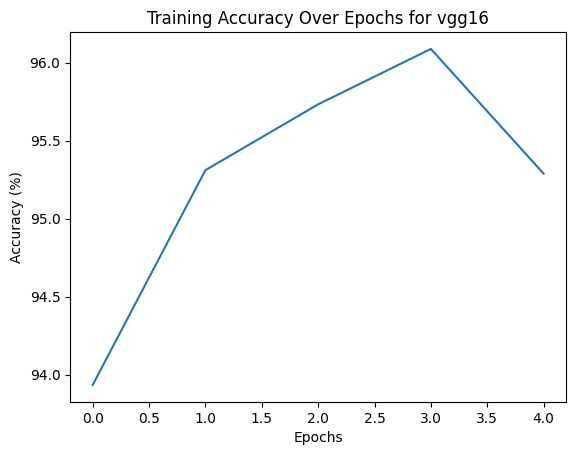

Training Loss values:
Epoch 0: Loss = 0.2117
Epoch 1: Loss = 0.1265
Epoch 2: Loss = 0.1062
Epoch 3: Loss = 0.0931
Epoch 4: Loss = 0.0842


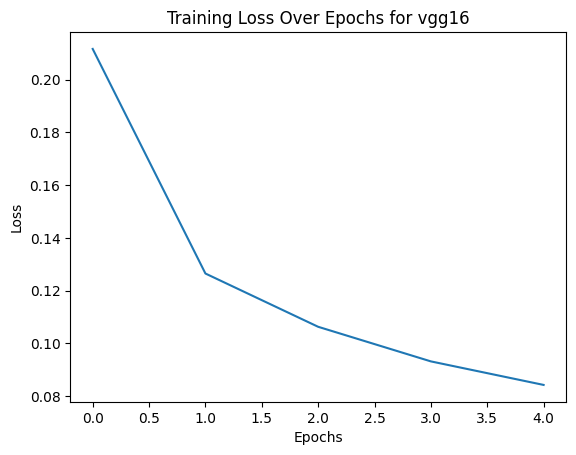

In [51]:
# Print the exact training accuracy values
print("Training Accuracy values:")
for epoch, acc in zip(epoch_nums, training_acc):
    print(f"Epoch {epoch}: Accuracy = {acc:.2f}%")

# Plot the training accuracy graph
plt.plot(epoch_nums, training_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs for vgg16')
plt.show()

# Print the exact training loss values
print("Training Loss values:")
for epoch, loss in zip(epoch_nums, training_loss):
    print(f"Epoch {epoch}: Loss = {loss:.4f}")

# Plot the training loss graph
plt.plot(epoch_nums, training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for vgg16')
plt.show()


In [52]:
#torch.save(model.state_dict(),'lung_vgg16.pt')

# GoogleNet

In [55]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary

# Step 1: Choose a Pre-trained Model
import torchvision.models as models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load GoogLeNet model and move it to the appropriate device (GPU or CPU)
model = models.googlenet(pretrained=True).to(device)

print(model)


c:\Users\Duke\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duke\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Duke/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:03<00:00, 13.9MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [56]:
# Step 2: Load and modify the model

# Number of classes for your problem
num_classes = 3
batch_size = 32
num_epochs = 5
learning_rate = 0.001

classes = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

# Load GoogLeNet and modify the final fully connected layer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = models.googlenet(pretrained=True).to(device)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)

# Check the modified model
print(model)

# Test function
def test(model, test_loader, device):
    # Set Model to evaluation mode
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images)
            _, predicted = torch.max(predicted_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total * 100
    return acc


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [57]:
# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the final fully connected layer (model.fc)
for param in model.fc.parameters():
    param.requires_grad = True


In [58]:
# Step 4: Data Preprocessing

import torchvision.transforms as transforms

# Define the data transformations
transform = [
    torchvision.transforms.Resize((224, 224)),  # Resize images to 224x224
    torchvision.transforms.ToTensor(),          # Convert images to PyTorch tensors
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize with mean=0.5 and std=0.5
]

# Combine the transformations
transformation = torchvision.transforms.Compose(transform)

# Path to the dataset
data_path = 'Lung Cancer'

# Create the dataset using ImageFolder (assumes the dataset is structured properly)
full_dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transformation)

# Split the dataset into training (70%) and testing (30%) sets
train_size = int(0.7 * len(full_dataset))  # 70% data for training
test_size = len(full_dataset) - train_size  # 30% data for testing
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Create DataLoader for training set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')


Training dataset size: 10500
Testing dataset size: 4500


In [59]:
# Step 5: Model Training

# Loss & Optimizer
criterion = torch.nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

# Initialize lists to track loss, accuracy, and epochs
epoch_loss = 0  # This will accumulate loss for the entire epoch
loss_list = []
training_loss = []
training_acc = []
epoch_nums = []

# Set the model to training mode
model.train()

# Total number of batches in the training set
total_step = len(train_loader)

# Start training the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Move data to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)  # No need to one-hot encode if using CrossEntropyLoss
        
        # Forward pass
        outputs = model(images)  # Pass the images through the model
        # outputs = torch.nn.functional.log_softmax(outputs, dim=1)  # No need for log_softmax here, CrossEntropyLoss expects raw logits

        # Calculate the loss (CrossEntropyLoss expects raw logits)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Backpropagate the loss
        optimizer.step()       # Update model weights

        # Accumulate loss for the epoch
        epoch_loss += loss.item()
        loss_list.append(epoch_loss)  # Append the cumulative loss

        # Log loss every 100 steps
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / (i + 1)
    training_loss.append(avg_loss)

    # Calculate accuracy on the test set after each epoch
    accuracy = test(model, test_loader, device)  
    training_acc.append(accuracy)

    # Store the epoch number for visualization or tracking purposes
    epoch_nums.append(epoch)

    # Print the results for the epoch
    print(f'Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Reset epoch loss for the next epoch
    epoch_loss = 0


Epoch [1/5], Step [100/329], Loss: 0.4011
Epoch [1/5], Step [200/329], Loss: 0.2041
Epoch [1/5], Step [300/329], Loss: 0.1974
Epoch 1 completed. Average Loss: 0.3480, Accuracy: 93.58%
Epoch [2/5], Step [100/329], Loss: 0.1469
Epoch [2/5], Step [200/329], Loss: 0.1071
Epoch [2/5], Step [300/329], Loss: 0.1459
Epoch 2 completed. Average Loss: 0.1521, Accuracy: 95.58%
Epoch [3/5], Step [100/329], Loss: 0.1781
Epoch [3/5], Step [200/329], Loss: 0.1428
Epoch [3/5], Step [300/329], Loss: 0.1417
Epoch 3 completed. Average Loss: 0.1222, Accuracy: 95.87%
Epoch [4/5], Step [100/329], Loss: 0.0753
Epoch [4/5], Step [200/329], Loss: 0.0663
Epoch [4/5], Step [300/329], Loss: 0.2407
Epoch 4 completed. Average Loss: 0.1076, Accuracy: 96.11%
Epoch [5/5], Step [100/329], Loss: 0.0871
Epoch [5/5], Step [200/329], Loss: 0.1133
Epoch [5/5], Step [300/329], Loss: 0.0434
Epoch 5 completed. Average Loss: 0.0961, Accuracy: 95.87%


In [60]:
# Set Model to evaluation mode
model.eval()

with torch.no_grad():
  correct = 0
  total = 0
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predicted_output = model(images)
    _,predicted = torch.max(predicted_output.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
acc = correct /total *100
print(acc)


# making predction based on the test dataset


95.86666666666666


In [61]:
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to store predictions and true labels
y_pred = []
y_true = []

# Set model to evaluation mode
model.eval()

# Disable gradient calculation during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        predicted_output = model(images)

        # Get the predicted class with the highest probability
        _, predicted = torch.max(predicted_output, 1)
        
        # Store predictions and true labels in lists
        y_pred.extend(predicted.cpu().numpy())  # Move predictions to CPU
        y_true.extend(labels.cpu().numpy())    # Move true labels to CPU

# Calculate confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Confusion Matrix:
[[1469    2   49]
 [   3 1465    0]
 [ 132    0 1380]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1520
           1       1.00      1.00      1.00      1468
           2       0.97      0.91      0.94      1512

    accuracy                           0.96      4500
   macro avg       0.96      0.96      0.96      4500
weighted avg       0.96      0.96      0.96      4500



Training Accuracy values:
Epoch 0: Accuracy = 93.58%
Epoch 1: Accuracy = 95.58%
Epoch 2: Accuracy = 95.87%
Epoch 3: Accuracy = 96.11%
Epoch 4: Accuracy = 95.87%


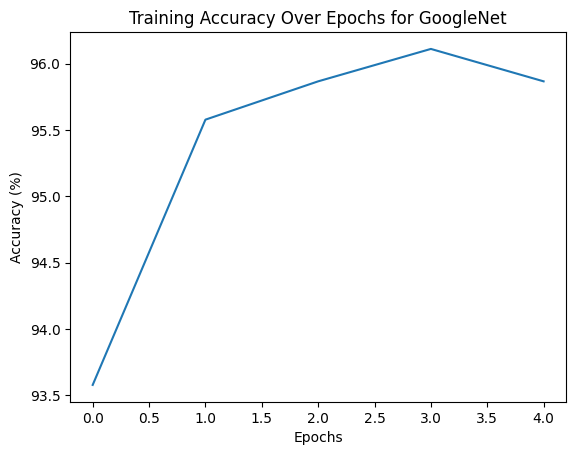

Training Loss values:
Epoch 0: Loss = 0.3480
Epoch 1: Loss = 0.1521
Epoch 2: Loss = 0.1222
Epoch 3: Loss = 0.1076
Epoch 4: Loss = 0.0961


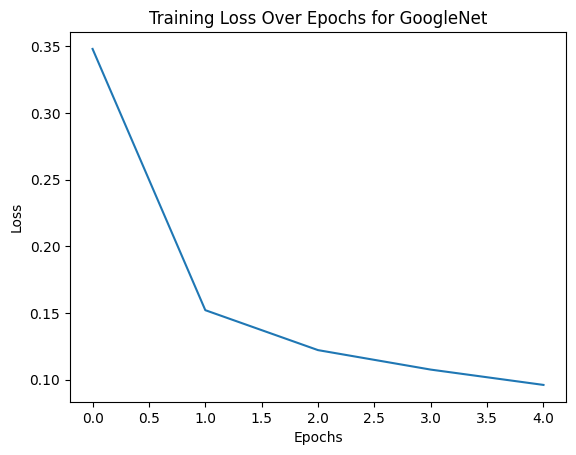

In [63]:
# Print the exact training accuracy values
print("Training Accuracy values:")
for epoch, acc in zip(epoch_nums, training_acc):
    print(f"Epoch {epoch}: Accuracy = {acc:.2f}%")

# Plot the training accuracy graph
plt.plot(epoch_nums, training_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs for GoogleNet')
plt.show()

# Print the exact training loss values
print("Training Loss values:")
for epoch, loss in zip(epoch_nums, training_loss):
    print(f"Epoch {epoch}: Loss = {loss:.4f}")

# Plot the training loss graph
plt.plot(epoch_nums, training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for GoogleNet')
plt.show()


# Model Comparison Visualization

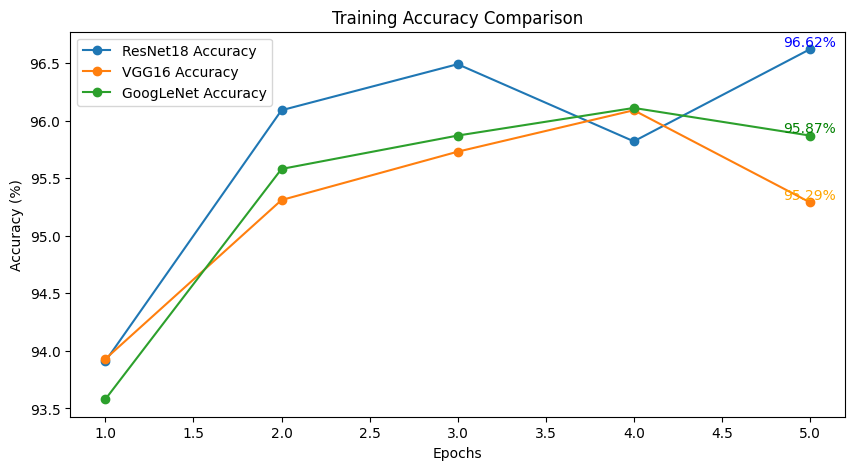

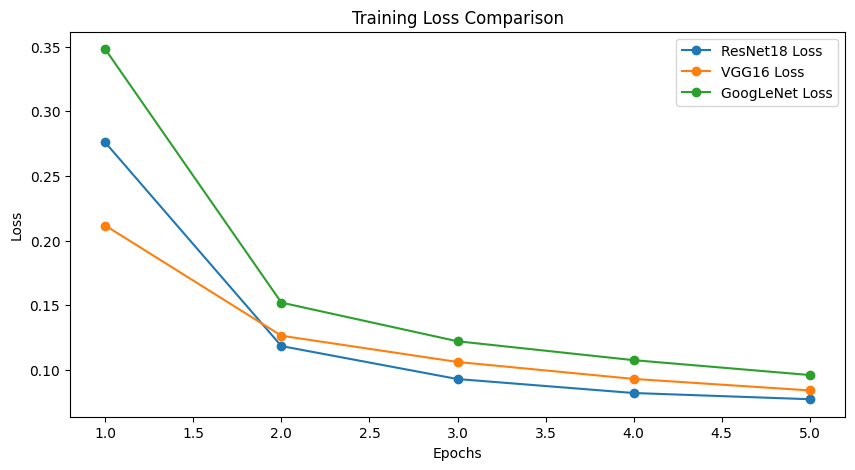

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Training Accuracy values for each model
epoch_nums = np.arange(1, 6)  # 5 Epochs

# ResNet18 Accuracy and Loss values
training_acc_resnet = [93.91, 96.09, 96.49, 95.82, 96.62]
training_loss_resnet = [0.2759, 0.1185, 0.0930, 0.0822, 0.0774]

# VGG16 Accuracy and Loss values
training_acc_vgg = [93.93, 95.31, 95.73, 96.09, 95.29]
training_loss_vgg = [0.2117, 0.1265, 0.1062, 0.0931, 0.0842]

# GoogLeNet Accuracy and Loss values
training_acc_google = [93.58, 95.58, 95.87, 96.11, 95.87]
training_loss_google = [0.3480, 0.1521, 0.1222, 0.1076, 0.0961]

# CoAtNet Loss values
#training_loss_coatnet = [0.3035203358186777, 0.2869129271039847, 0.2965641613698658, 0.3050301553494662, 0.27678161559450953]

# Plot training accuracy for all models
plt.figure(figsize=(10, 5))
plt.plot(epoch_nums, training_acc_resnet, label='ResNet18 Accuracy', marker='o')
plt.plot(epoch_nums, training_acc_vgg, label='VGG16 Accuracy', marker='o')
plt.plot(epoch_nums, training_acc_google, label='GoogLeNet Accuracy', marker='o')

# Annotating final accuracy for each model on the graph
plt.text(5, training_acc_resnet[-1], f'{training_acc_resnet[-1]:.2f}%', 
         ha='center', va='bottom', color='blue', fontsize=10)
plt.text(5, training_acc_vgg[-1], f'{training_acc_vgg[-1]:.2f}%', 
         ha='center', va='bottom', color='orange', fontsize=10)
plt.text(5, training_acc_google[-1], f'{training_acc_google[-1]:.2f}%', 
         ha='center', va='bottom', color='green', fontsize=10)

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.show()

# Plot training loss for all models
plt.figure(figsize=(10, 5))
plt.plot(epoch_nums, training_loss_resnet, label='ResNet18 Loss', marker='o')
plt.plot(epoch_nums, training_loss_vgg, label='VGG16 Loss', marker='o')
plt.plot(epoch_nums, training_loss_google, label='GoogLeNet Loss', marker='o')
#plt.plot(epoch_nums, training_loss_coatnet, label='CoAtNet Loss', marker='o', color='purple')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()
